<a href="https://colab.research.google.com/github/hodurang2/CV_project/blob/main/week5_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pwd

'/content'

In [ ]:
%cd /content/drive/MyDrive/CV_seminar_project

/content/drive/MyDrive/CV_seminar_project


In [ ]:
%pwd

'/content/drive/MyDrive/CV_seminar_project'

#1.데이터 셋 준비하기

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu' # cpu 지정
torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed_all(42)

device

'cuda'

In [ ]:
import torch.nn as nn # 파이토치 뉴럴 네트워크 layer 라이브러리리

# 하이퍼 파라미터
batch_size = 8
lr = 0.0001
epochs = 50
optimizer_name = 'adam'
model_name = 'resnet_50'
criterion = nn.CrossEntropyLoss().to(device) # cost funtion

In [ ]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 # albumentations 텐서화 함수
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
from torchvision import transforms
import os
import glob
import cv2
from dataset import Custom_dataset as C

root_path = '/content/drive/MyDrive/CV_seminar_project'

train_transforms = A.Compose([
    A.Resize(224,224), # 이미지 리사이즈
    A.Transpose(p=0.5), # 이미지 반전
    A.HorizontalFlip(p=0.5), 
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.ChannelShuffle(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 이미지넷 데이터셋 통계값으로 Normalize
    A.CoarseDropout(p=0.5),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 텐서타입은 안해줌
    ToTensorV2() # Normalize를 먼저하고 tensor화를 진행해야한다.
])

### Pytorch 데이터 클래스 생성
train_class = C(root_path=root_path, mode='train', transforms=train_transforms)
valid_class = C(root_path=root_path, mode='valid', transforms=test_transforms)
test_class = C(root_path=root_path, mode='test', transforms=test_transforms)

### Pytorch BatchLoader 생성 (학습에 이용할 최종 dataloader)
from torch.utils.data import DataLoader as DataLoader

train_loader = DataLoader(train_class, batch_size=batch_size, shuffle = True, num_workers=0)
valid_loader = DataLoader(valid_class, batch_size=batch_size, shuffle = False, num_workers=0)
test_loader = DataLoader(test_class, batch_size=batch_size, shuffle = False, num_workers=0) # 사실 필요하지않음

# 모델 불러오기

In [ ]:
from torchvision import models # 모델 라이브러리
import torch.nn as nn # 파이토치 뉴럴 네트워크 layer 라이브러리리

resnet_50 = models.resnet50(pretrained = True).to(device) # pretrained -> 산헹학습 여부
resnet_50.fc = nn.Linear(resnet_50.fc.in_features, 3).to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from torchsummary import summary # 모델 아키텍처 확인하는 함수수

summary(resnet_50, input_size = (3, 224, 224))

In [ ]:
optimizer = torch.optim.Adam(resnet_50.parameters(), lr = lr, weight_decay = 1e-8) # weight_decay = 학습을 할 수록 스텝을 줄여나갈수있게하는 param

#3. 모델 학습시키기

In [ ]:
train_acc_lst = []
train_loss_lst = []

test_acc_lst = []
test_loss_lst = []


for epoch in range(1, epochs):
  running_loss = 0.0
  test_running_loss = 0.0

  total = 0
  correct = 0

  train_acc = 0
  test_acc = 0
  resnet_50.train()
  for i, (train_img, train_label) in enumerate(train_loader):
    # gpu에 할당당
    train_img = train_img.to(device)
    train_label = train_label.to(device)
    optimizer.zero_grad( set_to_none = True ) # 계산했던 가중치 초기화화

    output = resnet_50(train_img) # 모델에 입력
    loss = criterion(output, train_label)
    loss.backward() # 미분
    optimizer.step() # 학습
    
    # loss & acc
    running_loss += loss.item()
    _, predictions = torch.max( output.data ,dim = 1 )

    total += train_label.size(0)
    correct += (predictions == train_label).sum().item()
    train_acc += (correct/total) * 100

  running_loss = round(running_loss/(i+1), 3) # 소수점 3번째 자리까지 출력력
  train_acc = round(train_acc/(i+1), 3)
  
  print(f'Trainset {epoch}/{epochs} Loss : {running_loss}, Accuracy : {train_acc}%')
  train_acc_lst.append(train_acc)
  train_loss_lst.append(running_loss)

  resnet_50.eval()
  for i, (valid_img, valid_label) in enumerate(valid_loader):
    # gpu에 할당당
    valid_img = valid_img.to(device)
    valid_label = valid_label.to(device)
    optimizer.zero_grad( set_to_none = True ) # 계산했던 가중치 초기화화

    output = resnet_50(valid_img) # 모델에 입력
    loss = criterion(output, valid_label)

    # loss & acc
    test_running_loss += loss.item()
    _, predictions = torch.max( output.data ,dim = 1 )

    total += valid_label.size(0)
    correct += (predictions == valid_label).sum().item()
    test_acc += (correct/total) * 100

  test_running_loss = round(test_running_loss/(i+1), 3) # 소수점 3번째 자리까지 출력력
  test_acc = round(test_acc/(i+1), 3)
  
  print(f'Testset {epoch}/{epochs} Loss : {test_running_loss}, Accuracy : {test_acc}% \n')
  test_acc_lst.append(test_acc)
  test_loss_lst.append(test_running_loss)

Trainset 1/10 Loss : 1.094, Accuracy : 37.628%
Testset 1/10 Loss : 1.076, Accuracy : 38.555% 

Trainset 2/10 Loss : 1.092, Accuracy : 39.385%
Testset 2/10 Loss : 1.072, Accuracy : 39.242% 

Trainset 3/10 Loss : 1.09, Accuracy : 39.097%
Testset 3/10 Loss : 1.078, Accuracy : 38.154% 

Trainset 4/10 Loss : 1.09, Accuracy : 40.936%
Testset 4/10 Loss : 1.077, Accuracy : 38.128% 

Trainset 5/10 Loss : 1.097, Accuracy : 40.173%
Testset 5/10 Loss : 1.08, Accuracy : 38.845% 

Trainset 6/10 Loss : 1.091, Accuracy : 42.701%
Testset 6/10 Loss : 1.08, Accuracy : 39.321% 

Trainset 7/10 Loss : 1.093, Accuracy : 39.489%
Testset 7/10 Loss : 1.076, Accuracy : 38.383% 

Trainset 8/10 Loss : 1.092, Accuracy : 40.313%
Testset 8/10 Loss : 1.079, Accuracy : 36.921% 

Trainset 9/10 Loss : 1.093, Accuracy : 40.964%
Testset 9/10 Loss : 1.074, Accuracy : 36.466% 



In [ ]:
test_acc_lst

[95.011, 92.852, 94.028, 94.065, 94.523, 94.51, 95.149, 93.159, 94.581]

Text(0.5, 1.0, 'loss')

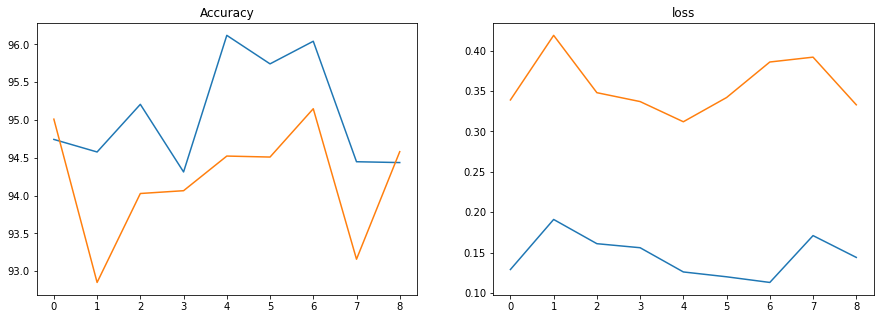

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

fig, axes = plt.subplots( nrows = 1, ncols = 2, figsize = (15, 5) )

axes[0].plot(np.arange(len(train_acc_lst)), train_acc_lst, label = 'train_acc')
axes[0].plot(np.arange(len(test_acc_lst)), test_acc_lst, label = 'test_acc')
axes[0].set_title('Accuracy')

axes[1].plot(np.arange(len(train_loss_lst)), train_loss_lst, label = 'train_loss')
axes[1].plot(np.arange(len(test_loss_lst)), test_loss_lst, label = 'test_loss')
axes[1].set_title('loss')


In [ ]:
train_acc_lst

[11041.912294112975]